## Stereo camera calibration & Get real 3D point coordinates
- [위치] F:\2024\stereo-camera   
- [날짜] 2024년 7월 29일   
- [환경] nox39  

In [68]:
import numpy as np 
import cv2
from tqdm import tqdm
import pdb

# Set the path to the images captured by the left and right cameras
pathL = "./data/stereoL/"
pathR = "./data/stereoR/"

#### 여러장의 좌, 우 카메라에서 찍은 chessboard영상을 입력하고 corner점을 추출

In [69]:
print("Extracting image coordinates of respective 3D pattern ....\n")

# Termination criteria for refining the detected corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

img_ptsL = []
img_ptsR = []
obj_pts = []

for i in tqdm(range(1,28)):
    imgL = cv2.imread(pathL+"img%d.png"%i)
    imgR = cv2.imread(pathR+"img%d.png"%i)
    imgL_gray = cv2.imread(pathL+"img%d.png"%i,0)
    imgR_gray = cv2.imread(pathR+"img%d.png"%i,0)
    #print(f"Read Left and Right Images for {i}")

    outputL = imgL.copy()
    outputR = imgR.copy()

    retR, cornersR =  cv2.findChessboardCorners(outputR,(9,6),None)
    retL, cornersL = cv2.findChessboardCorners(outputL,(9,6),None)

    #pdb.set_trace()
    if retR and retL:
        obj_pts.append(objp)
        cv2.cornerSubPix(imgR_gray,cornersR,(11,11),(-1,-1),criteria)
        cv2.cornerSubPix(imgL_gray,cornersL,(11,11),(-1,-1),criteria)
#         cv2.drawChessboardCorners(outputR,(9,6),cornersR,retR)
#         cv2.drawChessboardCorners(outputL,(9,6),cornersL,retL)
#         cv2.imshow('cornersR',outputR)
#         cv2.imshow('cornersL',outputL)
#         cv2.waitKey(0)

        img_ptsL.append(cornersL)
        img_ptsR.append(cornersR)

Extracting image coordinates of respective 3D pattern ....



100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 43.97it/s]


In [70]:
imgL.shape, imgR.shape

((480, 640, 3), (480, 640, 3))

#### 좌, 우 카메라를 각각 Calibration하고 인자를 얻음

In [71]:
print("Calculating left camera parameters ... ")
# Calibrating left camera
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(obj_pts,img_ptsL,imgL_gray.shape[::-1],None,None)
hL,wL= imgL_gray.shape[:2]
new_mtxL, roiL= cv2.getOptimalNewCameraMatrix(mtxL,distL,(wL,hL),1,(wL,hL))

print("Calculating right camera parameters ... ")
# Calibrating right camera
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(obj_pts,img_ptsR,imgR_gray.shape[::-1],None,None)
hR,wR= imgR_gray.shape[:2]
new_mtxR, roiR= cv2.getOptimalNewCameraMatrix(mtxR,distR,(wR,hR),1,(wR,hR))

Calculating left camera parameters ... 
Calculating right camera parameters ... 


#### 두 카메라의 인자값을 이용하여 stereo calibration

In [72]:
print("Stereo calibration .....")
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# Here we fix the intrinsic camara matrixes so that only Rot, Trns, Emat and Fmat are calculated.
# Hence intrinsic parameters are the same 

criteria_stereo= (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# This step is performed to transformation between the two cameras and calculate Essential and Fundamenatl matrix
retS, new_mtxL, distL, new_mtxR, distR, Rot, Trns, Emat, Fmat = cv2.stereoCalibrate(obj_pts,
                                                          img_ptsL,
                                                          img_ptsR,
                                                          new_mtxL,
                                                          distL,
                                                          new_mtxR,
                                                          distR,
                                                          imgL_gray.shape[::-1],
                                                          criteria_stereo,
                                                          flags)

Stereo calibration .....


#### Calibration인자값을 이용하여 image rectification에 필요한 행렬값 계산

In [29]:
# Once we know the transformation between the two cameras we can perform stereo rectification
# StereoRectify function
rectify_scale= 1 # if 0 image croped, if 1 image not croped
rect_l, rect_r, proj_mat_l, proj_mat_r, Q, roiL, roiR= cv2.stereoRectify(new_mtxL, distL, new_mtxR, distR,
                                                 imgL_gray.shape[::-1], Rot, Trns,
                                                 rectify_scale,(0,0))

# Use the rotation matrixes for stereo rectification and camera intrinsics for undistorting the image
# Compute the rectification map (mapping between the original image pixels and 
# their transformed values after applying rectification and undistortion) for left and right camera frames
Left_Stereo_Map1, Left_Stereo_Map2= cv2.initUndistortRectifyMap(new_mtxL, distL, rect_l, proj_mat_l,
                                             imgL_gray.shape[::-1], cv2.CV_16SC2)
Right_Stereo_Map1, Right_Stereo_Map2= cv2.initUndistortRectifyMap(new_mtxR, distR, rect_r, proj_mat_r,
                                              imgR_gray.shape[::-1], cv2.CV_16SC2)

In [30]:
print("Saving parameters ......")
cv_file = cv2.FileStorage("data/params_py.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",Left_Stereo_Map1)
cv_file.write("Left_Stereo_Map_y",Left_Stereo_Map2)
cv_file.write("Right_Stereo_Map_x",Right_Stereo_Map1)
cv_file.write("Right_Stereo_Map_y",Right_Stereo_Map2)
cv_file.release()

Saving parameters ......


#### Stereo image rectification

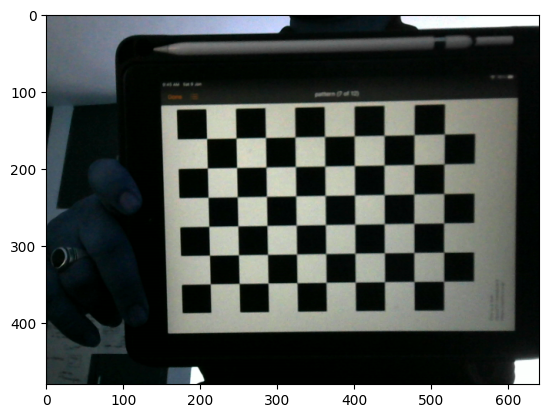

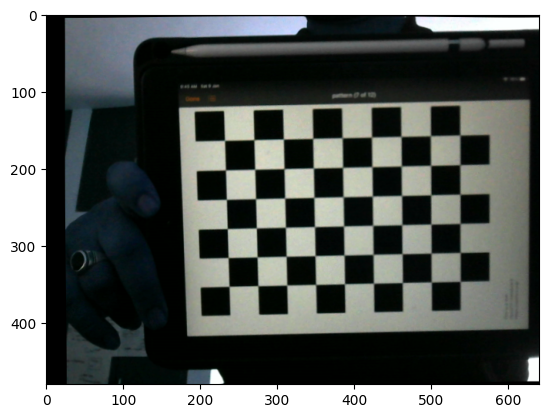

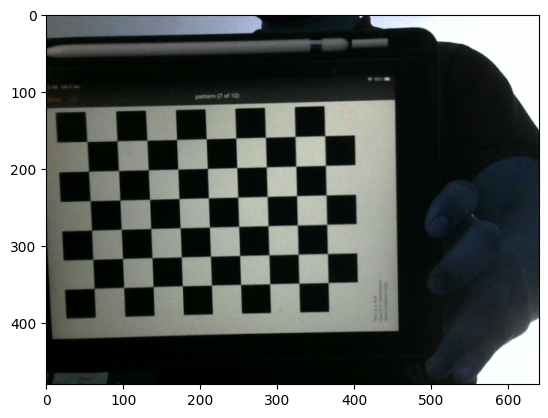

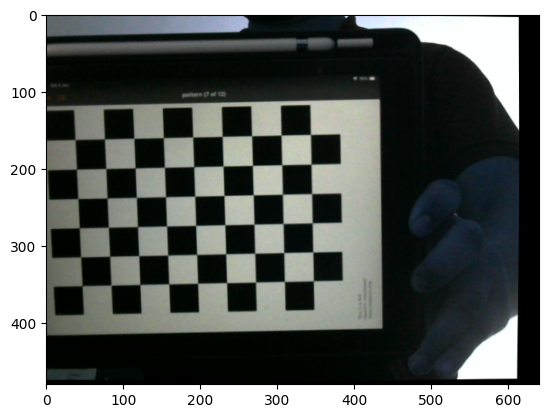

In [57]:
import matplotlib.pyplot as plt

undistorted_rectified_L = cv2.remap(imgL, Left_Stereo_Map1, Left_Stereo_Map2, cv2.INTER_LINEAR)


# 이미지 표시
plt.imshow(imgL, cmap='gray')
plt.show()
plt.imshow(undistorted_rectified_L, cmap='gray')
plt.show()


undistorted_rectified_R = cv2.remap(imgR, Right_Stereo_Map1, Right_Stereo_Map2, cv2.INTER_LINEAR)


# 이미지 표시
plt.imshow(imgR, cmap='gray')
plt.show()
plt.imshow(undistorted_rectified_R, cmap='gray')
plt.show()

#### Retified images내의 disparity값을 이용하여 3차원 좌표 계산

[[ 25.      45.125   25.4375 101.9375 101.9375 101.875   30.875   -1.
   -1.      -1.    ]
 [ 45.      45.125   45.125  101.875  101.875   42.75    31.1875  31.125
   -1.      34.9375]
 [ 44.9375  25.4375  25.0625  42.75    43.      42.75    31.1875  31.1875
   42.6875  50.8125]
 [ 45.      44.875   45.125  110.3125 110.3125  43.      31.625   -1.
   42.6875 110.0625]
 [110.3125  44.875   -1.     111.4375 111.4375  43.375   -1.      -1.
   -1.      -1.    ]
 [110.3125  96.75    -1.      -1.      43.6875  43.375   -1.      -1.
   -1.      -1.    ]
 [104.125  104.      -1.     104.     104.125   43.6875  -1.      -1.
   -1.      -1.    ]
 [104.125  104.     104.     104.125  104.125  104.125   -1.      -1.
   -1.      -1.    ]
 [110.6875 104.125  104.125  104.125  104.1875 104.1875 104.1875  40.125
   -1.      -1.    ]
 [110.125  108.3125 104.125  104.125  104.125  104.1875 104.125   40.125
   -1.      40.125 ]]
(480, 640) (480, 640, 3) [[  167.93567     93.03915    165.04733     41.1859

(-0.5, 639.5, 479.5, -0.5)

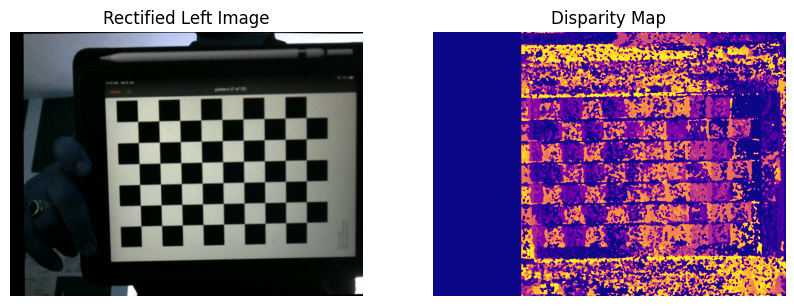

In [65]:
stereo = cv2.StereoSGBM_create(numDisparities=16*10, blockSize=5)
disparity = stereo.compute(undistorted_rectified_L, undistorted_rectified_R).astype(np.float32) / 16.0

# 시차를 3D 좌표로 재구성
points_3D = cv2.reprojectImageTo3D(disparity, Q)

print(disparity[240:240+10,320:320+10])
print(disparity.shape, points_3D.shape, points_3D[240:240+10,320:320+10,2])

# 결과 이미지 표시
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(undistorted_rectified_L, cmap='gray')
plt.title('Rectified Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(disparity, cmap='plasma')
plt.title('Disparity Map')
plt.axis('off')

In [46]:
disparity[200:300,200:300]

array([[  0.    ,   0.    ,   1.    , ...,  -1.    ,  -1.    ,   9.625 ],
       [  0.    ,   0.    ,   0.    , ...,  -1.    ,  -1.    ,  -1.    ],
       [ -1.    ,  -1.    ,  -1.    , ...,  -1.    ,  -1.    ,  -1.    ],
       ...,
       [ 40.875 ,  40.9375, 116.5625, ..., 128.25  , 128.25  , 128.    ],
       [ 40.875 ,  40.9375, 116.25  , ..., 128.375 , 128.9375, 128.875 ],
       [ 40.875 , 116.125 , 116.25  , ..., 119.1875, 129.    , 129.125 ]],
      dtype=float32)

In [18]:
len(Left_Stereo_Map), Left_Stereo_Map[0].shape, Left_Stereo_Map[1].shape, Right_Stereo_Map[0].shape, Left_Stereo_Map[1]

(2,
 (480, 640, 2),
 (480, 640),
 (480, 640, 2),
 array([[186, 186, 153, ..., 545, 545, 546],
        [186, 185, 152, ..., 545, 545, 578],
        [185, 152, 151, ..., 545, 577, 578],
        ...,
        [753, 784, 815, ..., 488, 489, 489],
        [721, 752, 784, ..., 488, 488, 489],
        [722, 753, 784, ..., 519, 487, 488]], dtype=uint16))

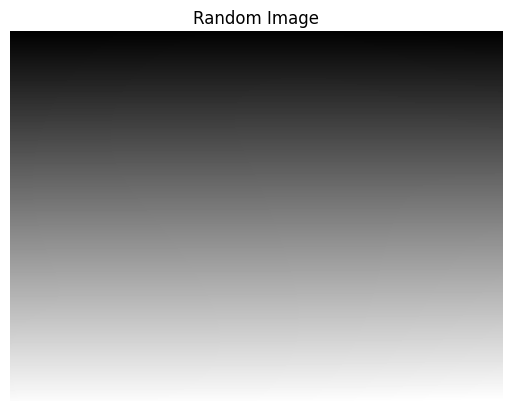

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# (640, 480) 크기의 0~255 사이 값이 들어 있는 랜덤 이미지 생성
#image = np.random.randint(0, 256, (480, 640), dtype=np.uint8)

# 이미지 표시
plt.imshow(Left_Stereo_Map[0], cmap='gray')
plt.show()

In [67]:
cv2.destroyAllWindows()  # 모든 열려 있는 image창을 닫음